In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
# import ast
# import json
# from statsmodels.distributions.empirical_distribution import ECDF
# #from scipy import stats
# from collections import Counter
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mpimg
from statsmodels.stats.proportion import proportions_ztest

In [2]:
# For local storage.
DATA_FOLDER = 'data/'
DATAFRAME_FILE = DATA_FOLDER + 'cleaned_data.pkl'

In [3]:
current_dir = Path.cwd()
frame_path = current_dir.joinpath(DATAFRAME_FILE)
shots_df = pd.read_pickle(str(frame_path))

In [4]:
pd.set_option('display.max_columns', None)
shots_df.head()

,game_id,season,is_playoff_game,venue,att_code,def_code,is_home,period,cum_time_elapsed,is_overtime,seconds_remaining,strength,att_score,def_score,lead_size,event,att_players,att_skaters,att_forwards,def_players,def_skaters,def_forwards,is_extra_attacker,is_empty_net,event_zone,shot_type,secondary_type,event_coord_x,event_coord_y,is_rebound,shot_dist,calc_dist,dist_difference,result,is_goal
0,2010020003,20102011,False,Hartwall Areena,CAR,MIN,False,1,65,False,1135,EV,0,0,0,SHOT,6,5,3,6,5,3,False,False,Off. Zone,Snap,Snap Shot,56.0,-15.0,False,37.0,36.249138,0.750862,Save,False
1,2010020003,20102011,False,Hartwall Areena,CAR,MIN,False,1,76,False,1124,EV,0,0,0,MISS,6,5,3,6,5,3,False,False,Off. Zone,Wrist,None,35.0,33.0,False,64.0,63.285069,0.714931,Wide of Net,False
2,2010020003,20102011,False,Hartwall Areena,MIN,CAR,True,1,97,False,1103,EV,0,0,0,MISS,6,5,3,6,5,3,False,False,Off. Zone,Wrist,None,87.0,-6.0,False,6.0,6.324555,0.324555,Wide of Net,False
3,2010020003,20102011,False,Hartwall Areena,MIN,CAR,True,1,213,False,987,EV,0,0,0,GOAL,6,5,3,6,5,3,False,False,Off. Zone,Wrist,Wrist Shot,78.0,3.0,False,12.0,11.401754,0.598246,Goal,True
5,2010020003,20102011,False,Hartwall Areena,MIN,CAR,True,1,233,False,967,EV,1,0,1,SHOT,6,5,3,6,5,3,False,False,Off. Zone,Wrist,Wrist Shot,54.0,38.0,False,52.0,51.662365,0.337635,Save,False


In [5]:
shots_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1113679 entries, 0 to 1529859
Data columns (total 35 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   game_id            1113679 non-null  object 
 1   season             1113679 non-null  object 
 2   is_playoff_game    1113679 non-null  bool   
 3   venue              1113679 non-null  object 
 4   att_code           1113679 non-null  object 
 5   def_code           1113679 non-null  object 
 6   is_home            1113679 non-null  bool   
 7   period             1113679 non-null  int64  
 8   cum_time_elapsed   1113679 non-null  int64  
 9   is_overtime        1113679 non-null  bool   
 10  seconds_remaining  1113679 non-null  int64  
 11  strength           1113679 non-null  object 
 12  att_score          1113679 non-null  int32  
 13  def_score          1113679 non-null  int32  
 14  lead_size          1113679 non-null  int32  
 15  event              1113679 non-n

Start with some sanity checks on the data. The majority of NHL games are 60 minutes long, with a sizable minority having an additional time for overtime. We would expect the median event time to be roughly 30 minutes into the game, which is true.

In [6]:
shots_df['cum_time_elapsed'].describe()

count    1.113679e+06
mean     1.836203e+03
std      1.058958e+03
min      0.000000e+00
25%      9.330000e+02
50%      1.823000e+03
75%      2.727000e+03
max      9.027000e+03
Name: cum_time_elapsed, dtype: float64

Likewise, most NHL periods are 20 minutes long. Only regular season overtimes are shorter, at 5 minutes. We would expect the median time remaining in a period to be about 10 minutes. This is again what we find.

In [7]:
shots_df['seconds_remaining'].describe()

count    1.113679e+06
mean     5.915491e+02
std      3.480906e+02
min      0.000000e+00
25%      2.850000e+02
50%      5.950000e+02
75%      8.950000e+02
max      1.200000e+03
Name: seconds_remaining, dtype: float64

Overtimes are sudden-death, where a single goal ends the game. Since overtimes will often not last the entire scheduled time, we would expect the median regular-season overtime event to take place with over 2:30 remaining and the median playoff overtime event to take place with over 10:00 remining.

In [8]:
# Regular season overtimes
shots_df[(shots_df['is_overtime']) & (~shots_df['is_playoff_game'])]['seconds_remaining'].describe()

count    16931.000000
mean       155.298269
std         84.666807
min          0.000000
25%         85.000000
50%        163.000000
75%        229.000000
max        298.000000
Name: seconds_remaining, dtype: float64

In [9]:
# Playoff overtimes
shots_df[(shots_df['is_overtime']) & (shots_df['is_playoff_game'])]['seconds_remaining'].describe()

count    3969.000000
mean      763.039809
std       317.026125
min         0.000000
25%       537.000000
50%       830.000000
75%      1034.000000
max      1195.000000
Name: seconds_remaining, dtype: float64

### Players on Ice

The standard situation in ice hockey sees each team providing six players on the ice, usually consisting of one goaltender (or "goalie") and five other players (often called "skaters" or "attackers"). The attackers can be further divided into forwards and defense. In most situations, teams play three forwards with two players on defense. Generally, forwards focus on scoring goals while the defense focuses on preventing them. The only positional restriction is that teams are only allowed one goaltender at any one time. Teams are not required to have a goalie on the ice and in some situations will "pull" the goaltender for an extra attacker. 

If a player commits a penalty, the usual punishment is for that player to be removed from the ice for a fixed length of time. During that time, the team is unable to replace the player on the ice. Teams may be reduced to four players on the ice due to penalties, but no further. When one team has more players on the ice than the other, the team with the player advantage is said to be on a "power play". The other team is described as "short-handed". If teams have the same number of players on the ice, the teams are said to be at "even strength". If a team has pulled their goalie for an extra attacker, that doesn't change these labels.

Rules fix the number of players on the ice to be between four and six, with the most common situation being six. Since teams are allowed at most one goalie, the number of skaters is also fixed between three and six, most commonly five. Since there is no restriction on the number of forwards, there may be anywhere from zero to six forwards on the ice.

Examining the fields counting the players on the ice, it is easy to see that these conditions hold true for this data set.

In [10]:
player_count_columns = ['att_players', 'def_players', 'att_skaters', 'def_skaters', 'att_forwards', 'def_forwards'] 
shots_df[player_count_columns].describe()

,att_players,def_players,att_skaters,def_skaters,att_forwards,def_forwards
count,1.113504e+06,1.113504e+06,1.113504e+06,1.113504e+06,1.113504e+06,1.113504e+06
mean,5.939110e+00,5.806168e+00,4.957383e+00,4.810951e+00,3.055752e+00,2.825553e+00
std,2.659217e-01,4.308647e-01,2.987497e-01,4.378626e-01,4.207040e-01,4.526593e-01
min,4.000000e+00,4.000000e+00,3.000000e+00,3.000000e+00,1.000000e+00,0.000000e+00
25%,6.000000e+00,6.000000e+00,5.000000e+00,5.000000e+00,3.000000e+00,3.000000e+00
50%,6.000000e+00,6.000000e+00,5.000000e+00,5.000000e+00,3.000000e+00,3.000000e+00
75%,6.000000e+00,6.000000e+00,5.000000e+00,5.000000e+00,3.000000e+00,3.000000e+00
max,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00


Teams are usually at even strength. When penalties occur, teams that are on the power-play have a numerical advantage and generally try to press that for shot attempts. Short-handed teams can produce shot attempts, but these are comparatively rarer than attempts while on the power play. This is confirmed by examining the data frame.

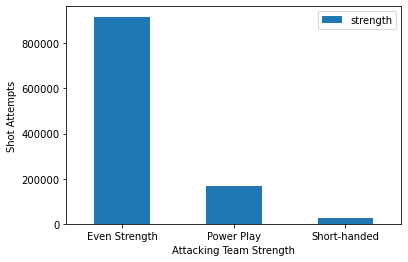

In [11]:
pd.DataFrame(shots_df['strength'].value_counts()) \
    .rename({'EV': 'Even Strength', 'PP': 'Power Play', 'SH': 'Short-handed'}) \
    .plot(kind='bar', xlabel='Attacking Team Strength', ylabel='Shot Attempts', rot=0);

Teams with more players on the ice tend to produce more shot attempts and these shots tend to be more successful. When comparing by number of players on the ice, this becomes apparent.

In [12]:
def create_pivot_players_on_ice(strength, pivot_col, aggfunc):
    col_def = 'def_' + pivot_col
    col_att = 'att_' + pivot_col
    if strength == 'ALL':
        pivot_df = shots_df
    else:
        pivot_df = shots_df[shots_df['strength']==strength]
    pivot_df = pivot_df.pivot_table(values='is_goal', index=col_def, columns=col_att, aggfunc=aggfunc, fill_value=0)
    pivot_df.columns.name = pivot_col.title() + ' (Attacking)'
    pivot_df.index.name = pivot_col.title() + ' (Defending)'
    return pivot_df

In [13]:
def create_heatmap_players_on_ice(strength, pivot_col, ax, fmt, title, aggfunc='count', palette='Reds', vmax=None):
    df = create_pivot_players_on_ice(strength, pivot_col, aggfunc)
    mask = df==0
    if (vmax is None):
        sns.heatmap(df, ax=ax, cmap=palette, annot=True, fmt=fmt, linewidth=0.5, mask=mask, vmin=0)
    else:
        sns.heatmap(df, ax=ax, cmap=palette, annot=True, fmt=fmt, linewidth=0.5, mask=mask, vmin=0, vmax=vmax)
    ax.set_title(title)

Interestingly, there are some situations which shouldn't be possible by definition. For even strength situations, players should have the same number of players on the ice. For power-play events, the attacking team should have more players on the ice. Conversely, when the attacker is short-handed, they should have fewer players. These turn out to be a small proportion of shot attempts however.

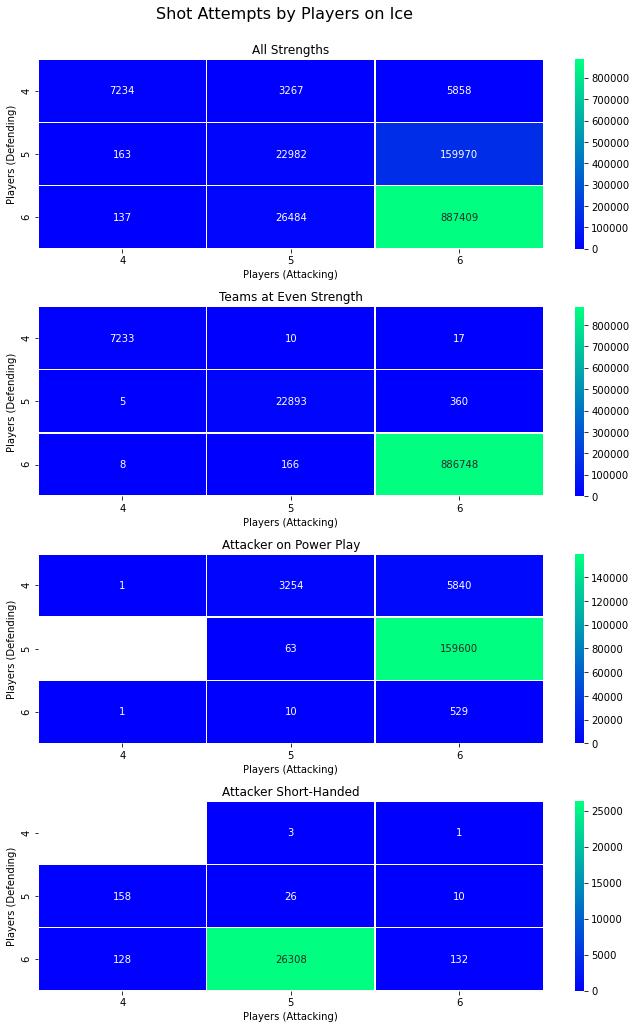

In [14]:
fig, axs = plt.subplots(4,1, figsize=(10,15));
palette='winter'
create_heatmap_players_on_ice('ALL', 'players', axs[0], '0.0f', 'All Strengths', 'count', palette)
create_heatmap_players_on_ice('EV', 'players', axs[1], '0.0f', 'Teams at Even Strength', 'count', palette)
create_heatmap_players_on_ice('PP', 'players', axs[2], '0.0f', 'Attacker on Power Play', 'count', palette)
create_heatmap_players_on_ice('SH', 'players', axs[3], '0.0f', 'Attacker Short-Handed', 'count', palette)
plt.suptitle('Shot Attempts by Players on Ice', fontsize=16, x=0.4)
fig.tight_layout(rect=[0, 0.03, 0.95, 0.98])

Unsuprisingly, shots are more likely to be successful when there are fewer defenders on the ice. As before, there are issues with situations which shouldn't be possible.

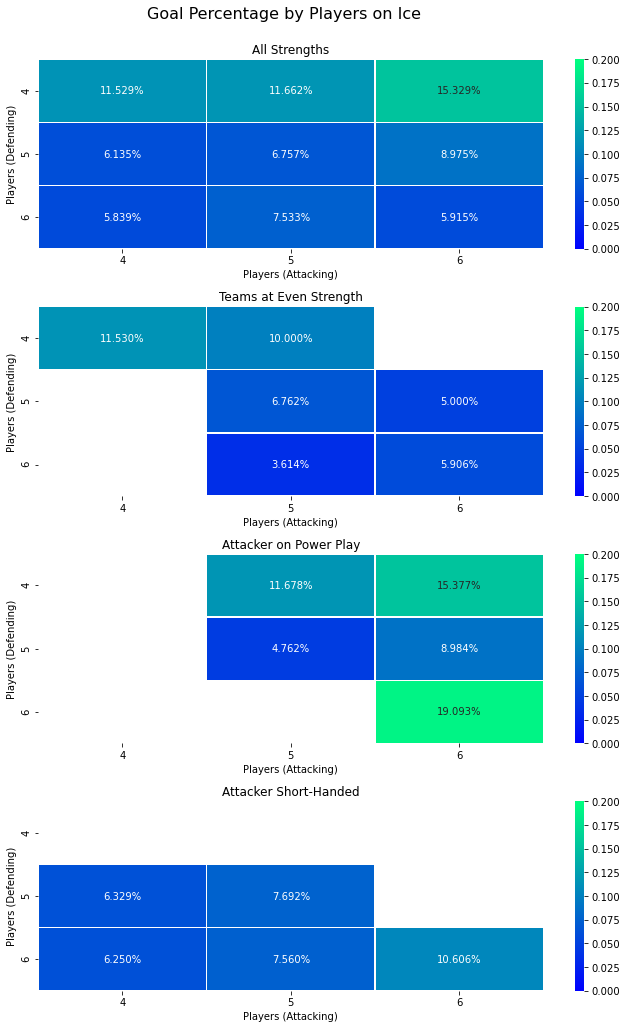

In [15]:
fig, axs = plt.subplots(4,1, figsize=(10,15));
palette='winter'
vmax = 0.2
create_heatmap_players_on_ice('ALL', 'players', axs[0], '0.3%', 'All Strengths', 'mean', palette, vmax=vmax)
create_heatmap_players_on_ice('EV', 'players', axs[1], '0.3%', 'Teams at Even Strength', 'mean', palette, vmax=vmax)
create_heatmap_players_on_ice('PP', 'players', axs[2], '0.3%', 'Attacker on Power Play', 'mean', palette, vmax=vmax)
create_heatmap_players_on_ice('SH', 'players', axs[3], '0.3%', 'Attacker Short-Handed', 'mean', palette, vmax=vmax)
plt.suptitle('Goal Percentage by Players on Ice', fontsize=16, x=0.4)
fig.tight_layout(rect=[0, 0.03, 0.95, 0.98])

Interestingly, there are some situations which shouldn't be definitionally possible. For even strength situations, players should have the same number of players on the ice. For power-play events, the attacking team should have more players on the ice. Conversely, when the attacker is short-handed, they should have fewer players.

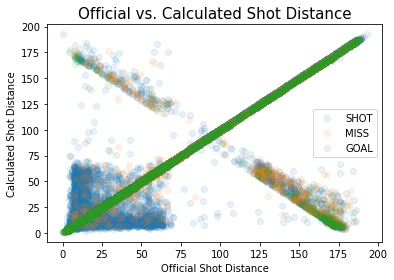

In [16]:
event_types = shots_df.event.unique()
for event_type in event_types:
    plt.scatter(x='shot_dist', y='calc_dist', data=shots_df[shots_df.event==event_type], label=event_type, alpha=0.1);
plt.xlabel('Official Shot Distance');
plt.ylabel('Calculated Shot Distance');
plt.title('Official vs. Calculated Shot Distance', fontsize=15);
plt.legend();

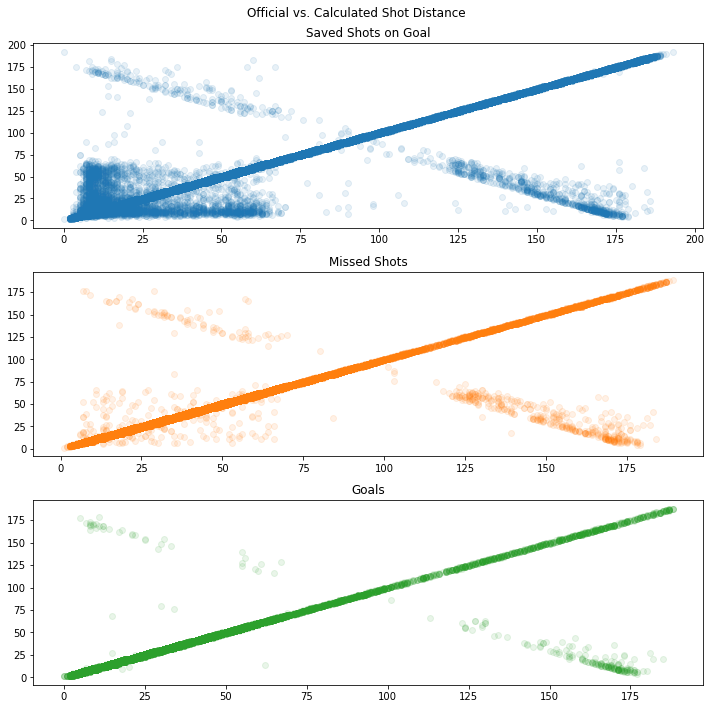

In [17]:
fig, axs = plt.subplots(3,1, figsize=(10,10));
axs[0].scatter(x='shot_dist', y='calc_dist', data=shots_df[shots_df.event=='SHOT'], 
               color=next(axs[0]._get_lines.prop_cycler)['color'], alpha=0.1);
axs[0].set_title('Saved Shots on Goal');
axs[1].scatter(x='shot_dist', y='calc_dist', data=shots_df[shots_df.event=='MISS'], 
               color=next(axs[0]._get_lines.prop_cycler)['color'], alpha=0.1);
axs[1].set_title('Missed Shots');
axs[2].scatter(x='shot_dist', y='calc_dist', data=shots_df[shots_df.event=='GOAL'], 
               color=next(axs[0]._get_lines.prop_cycler)['color'], alpha=0.1);
axs[2].set_title('Goals');
plt.suptitle('Official vs. Calculated Shot Distance');
fig.tight_layout()

# There seems to be a systematic difference that can be seen in saves and missed shots that is separate from the mis-coding for attacking ends.

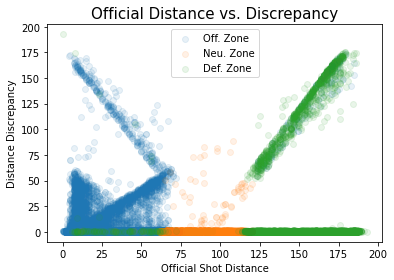

In [18]:
event_zones = shots_df.event_zone.unique()[:3]
for zone in event_zones:
    plt.scatter(x='shot_dist', y='dist_difference', data=shots_df[shots_df.event_zone==zone], label=zone, alpha=0.1);
plt.xlabel('Official Shot Distance');
plt.ylabel('Distance Discrepancy');
plt.title('Official Distance vs. Discrepancy', fontsize=15);
plt.legend();

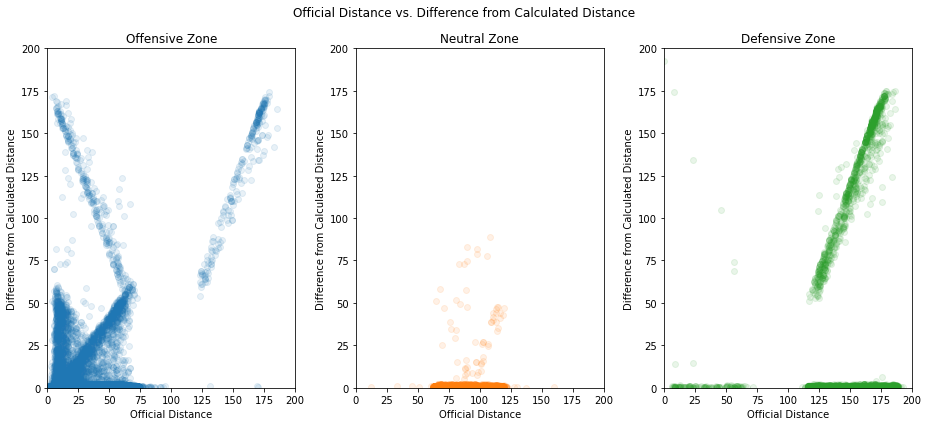

In [19]:
fig, axs = plt.subplots(1,3,figsize=(13,6));
for i in range(3):
    axs[i].set_xlabel('Official Distance');
    axs[i].set_ylabel('Difference from Calculated Distance');
    axs[i].set_xlim(0,200);
    axs[i].set_ylim(0,200);
axs[0].scatter(x='shot_dist', y='dist_difference', data=shots_df[shots_df.event_zone=='Off. Zone'], 
               color=next(axs[0]._get_lines.prop_cycler)['color'], label=zone, alpha=0.1);
axs[0].set_title('Offensive Zone');
axs[1].scatter(x='shot_dist', y='dist_difference', data=shots_df[shots_df.event_zone=='Neu. Zone'], 
               color=next(axs[0]._get_lines.prop_cycler)['color'], label=zone, alpha=0.1);
axs[1].set_title('Neutral Zone');
axs[2].scatter(x='shot_dist', y='dist_difference', data=shots_df[shots_df.event_zone=='Def. Zone'], 
               color=next(axs[0]._get_lines.prop_cycler)['color'], label=zone, alpha=0.1);
axs[2].set_title('Defensive Zone');
plt.suptitle('Official Distance vs. Difference from Calculated Distance');

fig.tight_layout()

No shots less than 60 feet from the goal can be correctly coded as defensive zone. There are a number of shots where coordinates and distance agree where the zone is obviously-miscoded. This will be handled later.

There are two other patterns seen in the shots. The first is a line with slope near 1 in the offensive zone plot. The other is a near vertical-line associated with very short distance shots.

The offensive zone is the set of coordinates with $x$-coordinate of at least 25. The $y$-coordinate can vary between -42.5 and 42.5. Since the center of the goal is located at $(89,0)$, the longest possible shot in the offensive zone has length $\sqrt{(89-25)^2 + (42.5)^2} \approx 77$

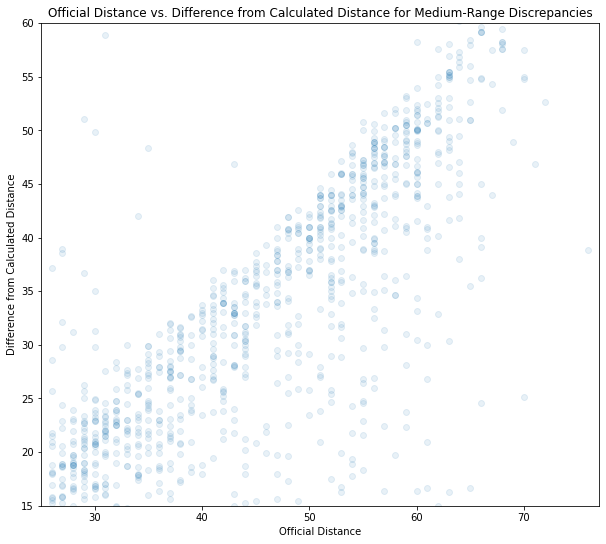

In [20]:
fig = plt.figure(figsize=(10,60))
plt.gca().set_aspect(aspect='equal')
plt.xlim(25,77);
plt.ylim(15,60);
plt.scatter(x='shot_dist', y='dist_difference', data=shots_df[(shots_df.shot_dist > 25) 
                                                                & (shots_df.shot_dist < 77) 
                                                                & (shots_df.dist_difference > 10)], alpha=0.1);
plt.title('Official Distance vs. Difference from Calculated Distance for Medium-Range Discrepancies');
plt.xlabel('Official Distance');
plt.ylabel('Difference from Calculated Distance');

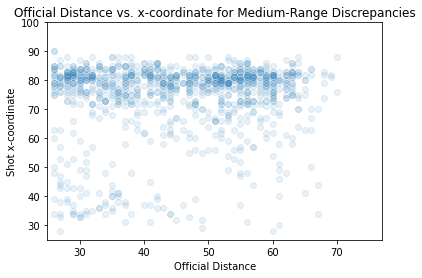

In [21]:
plt.xlim(25,77);
plt.ylim(25,100);
plt.scatter(x='shot_dist', y='event_coord_x', data=shots_df[(shots_df.shot_dist > 25) 
                                                              & (shots_df.shot_dist < 77) 
                                                              & (shots_df.dist_difference > 10)], alpha=0.1);
plt.xlabel('Official Distance');
plt.ylabel('Shot x-coordinate');
plt.title('Official Distance vs. x-coordinate for Medium-Range Discrepancies');

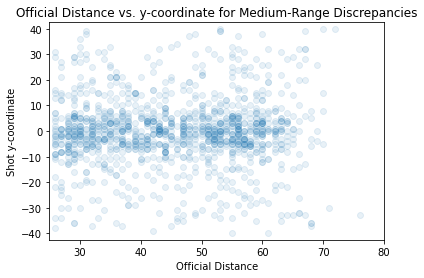

In [22]:
plt.xlim(25,80);
plt.ylim(-42.5, 42.5);
plt.scatter(x='shot_dist', y='event_coord_y', data=shots_df[(shots_df.shot_dist > 25) 
                                                              & (shots_df.shot_dist < 77) 
                                                              & (shots_df.dist_difference > 10)], alpha=0.1);
plt.xlabel('Official Distance');
plt.ylabel('Shot y-coordinate');
plt.title('Official Distance vs. y-coordinate for Medium-Range Discrepancies');

Interestingly enough, most of the shots considered here seem to have coordinates near $x=80$ and $y=0$. This is just in front of the goal, which suggests that these might be shots which were found after-the-fact to have actually been deflected shots. This is a not-uncommon determination in the NHL, which results in an adjustment to the shooting player and distance in the statistics.

In [23]:
shots_df[(shots_df.shot_dist > 25) 
           & (shots_df.shot_dist < 77) 
           & (shots_df.dist_difference > 10)]['shot_type'].value_counts(normalize=True)

Wrist        0.498776
Slap         0.320000
Snap         0.143673
Backhand     0.026939
Tip-In       0.008163
Deflected    0.002449
Name: shot_type, dtype: float64

In [24]:
shots_df[(shots_df.shot_dist > 25) 
           & (shots_df.shot_dist < 77) 
           & (shots_df.dist_difference > 10)]['secondary_type'].value_counts(normalize=True)

Wrist Shot     0.550274
Backhand       0.159963
Snap Shot      0.107861
Slap Shot      0.106947
Tip-In         0.056673
Deflected      0.012797
Wrap-around    0.005484
Name: secondary_type, dtype: float64

The category `secondary_type` is taken from the live feed, which is the data source which can be adjusted later. The category `shot_type` is extracted from the play-by-play. Notice that there are far more shots categorized as `Tip-In` or `Deflected` in the `secondary_type` column and far fewer `Slap` (`Slap Shot`) values. This suggests that this variation arises from post-game adjustment to the shot location. Additionally, this would suggest that the event-coordinates for these shots should be preferred.

Now, conduct a similar analysis for shots indicated at extremely short-range.

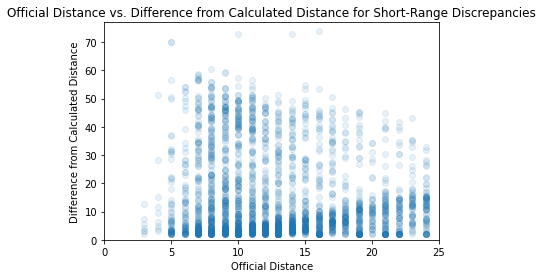

In [25]:
plt.xlim(0,25);
plt.ylim(0,77);
plt.scatter(x='shot_dist', y='dist_difference', data=shots_df[(shots_df.shot_dist < 25)
                                                                & (shots_df.dist_difference >= 2)],alpha=0.1);
plt.title('Official Distance vs. Difference from Calculated Distance for Short-Range Discrepancies');
plt.xlabel('Official Distance');
plt.ylabel('Difference from Calculated Distance');

Toward the bottom of this plot, it is possible to see the overlap with the preceding analysis. Consequently, the data will be replotted to exclude shots where the coordinates report short distances.

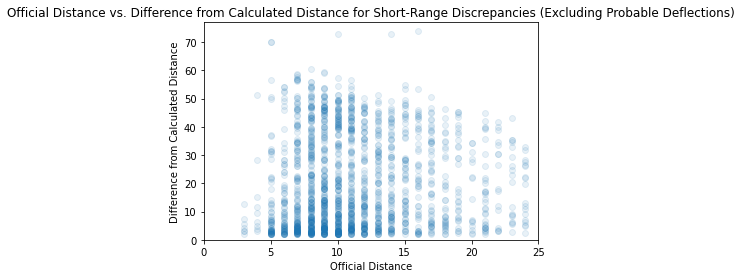

In [26]:
plt.xlim(0,25);
plt.ylim(0,77);
plt.scatter(x='shot_dist', y='dist_difference', data=shots_df[(shots_df.shot_dist < 25)
                                                                & (shots_df.dist_difference >= 2)
                                                                & (shots_df.calc_dist > shots_df.shot_dist)],alpha=0.1);
plt.title('Official Distance vs. Difference from Calculated Distance for Short-Range Discrepancies ' \
            + '(Excluding Probable Deflections)');
plt.xlabel('Official Distance');
plt.ylabel('Difference from Calculated Distance');

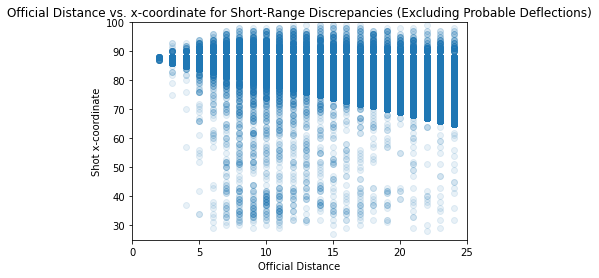

In [27]:
plt.xlim(0,25);
plt.ylim(25,100);
plt.scatter(x='shot_dist', y='event_coord_x', data=shots_df[(shots_df.shot_dist < 25) 
                                                              & (shots_df.shot_dist >= 2) 
                                                              & (shots_df.calc_dist > shots_df.shot_dist)], alpha=0.1);
plt.xlabel('Official Distance');
plt.ylabel('Shot x-coordinate');
plt.title('Official Distance vs. x-coordinate for Short-Range Discrepancies (Excluding Probable Deflections)');

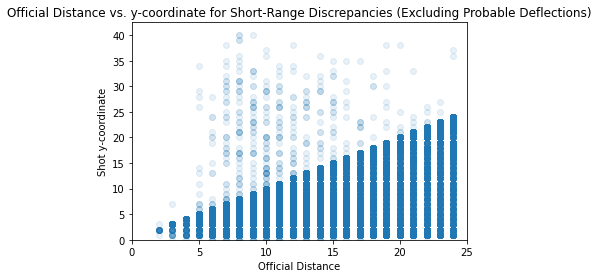

In [28]:
plt.xlim(0,25);
plt.ylim(0,42.5);
plt.scatter(x='shot_dist', y='event_coord_y', data=shots_df[(shots_df.shot_dist < 25) 
                                                              & (shots_df.shot_dist >= 2) 
                                                              & (shots_df.calc_dist > shots_df.shot_dist)], alpha=0.1);
plt.xlabel('Official Distance');
plt.ylabel('Shot y-coordinate');
plt.title('Official Distance vs. y-coordinate for Short-Range Discrepancies (Excluding Probable Deflections)');

In [29]:
shots_df[(shots_df.shot_dist < 25) 
           & (shots_df.shot_dist >= 2) 
           & (shots_df.calc_dist > shots_df.shot_dist)]['shot_type'].value_counts(normalize=True)

Wrist          0.509966
Backhand       0.181734
Tip-In         0.100660
Snap           0.097225
Wrap-around    0.049489
Deflected      0.036575
Slap           0.024352
Name: shot_type, dtype: float64

In [30]:
shots_df[(shots_df.shot_dist < 25) 
           & (shots_df.shot_dist >= 2) 
           & (shots_df.calc_dist > shots_df.shot_dist)]['secondary_type'].value_counts(normalize=True)

Wrist Shot     0.532360
Backhand       0.181867
Snap Shot      0.103200
Tip-In         0.075798
Wrap-around    0.054122
Slap Shot      0.026651
Deflected      0.026002
Name: secondary_type, dtype: float64

While the trend isn't as prevalent as in the preceding analysis, there does appear to be a slight recategorization of shots away from deflected shots (`Tip-In` and `Deflected`). This may also indicate the result of post-game recoding of shots. Consequently, the coordinates will be used unchanged here.

Zone-miscoding still must be handled. Defensive zone shots are rare due to the length and the low-probability of scoring a goal. The working presumption should be that if the distances disagree, this is likely a consequence of a mis-coding which had one of the sources incorrectly mark the shot as coming from the defensive zone. This leads to the following.
1. Shots coded as the offensive zone: This zone coding is presumptively correct. Any coordinates which appear to place the shot outside of the offensive zone should be rotated to conform to this.
2. Shots coded as the neutral zone: There doesn't appear to be any common bias with these shots. Particularly there is no strong presumption for correctness of one set of data, so these shots will be left unchanged.
3. Shots coded as the defensive zone: This zone coding is presumptively incorrect. There is a considerable minority of shots which distance and coordinates seem to indicate actually took place in the offensive zone. These coordinates will be accepted as correct. For official shot distances which agree with being taken from the defensive zone, the coordinates will take precedence. This means that if the coordinates appear to indicate a shot from the offensive zone, these will be used instead.

The only listed category that requires adjustment to the coordinates are shots coded as offensive zone shots.

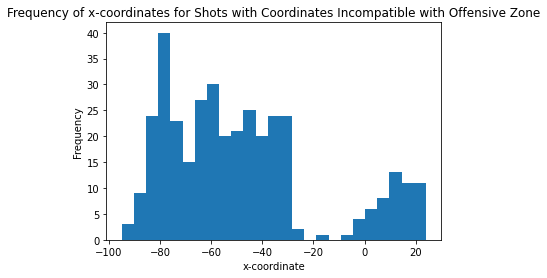

In [31]:
plt.hist(x='event_coord_x',data=shots_df[(shots_df.event_zone=='Off. Zone') & (shots_df.event_coord_x < 25)], bins=25);
plt.xlabel('x-coordinate');
plt.ylabel('Frequency');
plt.title('Frequency of x-coordinates for Shots with Coordinates Incompatible with Offensive Zone');

In [32]:
shots_df[(shots_df.event_zone=='Off. Zone') & (shots_df.event_coord_x < 25)]['event_coord_x'].describe()

count    362.000000
mean     -48.301105
std       30.244717
min      -95.000000
25%      -73.000000
50%      -55.000000
75%      -35.000000
max       24.000000
Name: event_coord_x, dtype: float64

Almost all of these shot attempts have $x$-coordinate less than $-25$. These shots would seem to be coming from the defensive zone. These are likely incorrect, and should be adjusted. Offensive zone shots with $x \leq -25$ will be adjusted.

In [33]:
adjusted_x = np.where((shots_df.event_zone=='Off. Zone') & (shots_df.event_coord_x < -25), 
                      -shots_df.event_coord_x,
                      shots_df.event_coord_x)
adjusted_y = np.where((shots_df.event_zone=='Off. Zone') & (shots_df.event_coord_x < -25), 
                      -shots_df.event_coord_y,
                      shots_df.event_coord_y)
shots_df['event_coord_x'] = adjusted_x
shots_df['event_coord_y'] = adjusted_y

In [34]:
shots_df['event_zone'].unique()

array(['Off. Zone', 'Neu. Zone', 'Def. Zone', None, nan], dtype=object)

In [35]:
def correct_zone(x):
    if (x <= -25):
        return 'Def. Zone'
    elif (x >= 25):
        return 'Off. Zone'
    elif x is None:
        return None
    else:
        return 'Neu. Zone'
shots_df['event_zone'] = shots_df.event_coord_x.apply(lambda x: correct_zone(x))

In [36]:
shots_df['event_zone'].unique()

array(['Off. Zone', 'Neu. Zone', 'Def. Zone'], dtype=object)

Since some coordinates were adjusted, the calculated distances need to be re-calculated.

In [37]:
shots_df['calc_dist'] = np.sqrt((shots_df['event_coord_x']-89)**2 + shots_df['event_coord_y']**2)
shots_df['dist_difference'] = np.abs(shots_df['calc_dist'] - shots_df['shot_dist'])

Re-examine the earlier analysis with these adjustments.

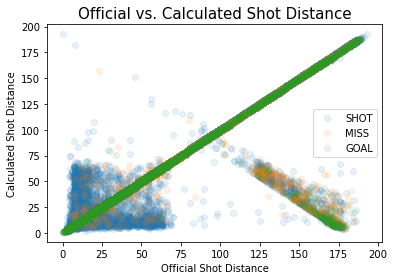

In [38]:
event_types = shots_df.event.unique()
for event_type in event_types:
    plt.scatter(x='shot_dist', y='calc_dist', data=shots_df[shots_df.event==event_type], label=event_type, alpha=0.1);
plt.xlabel('Official Shot Distance');
plt.ylabel('Calculated Shot Distance');
plt.title('Official vs. Calculated Shot Distance', fontsize=15);
plt.legend();

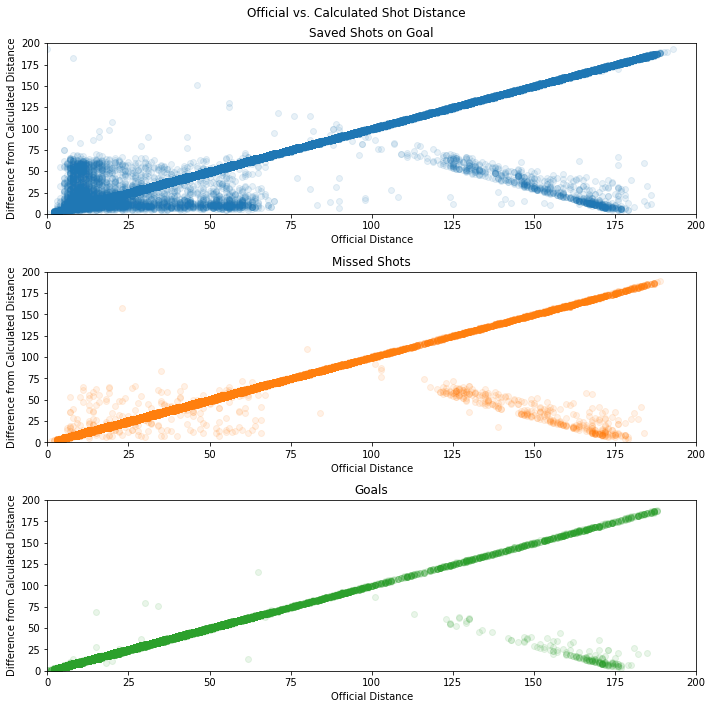

In [39]:
fig, axs = plt.subplots(3,1, figsize=(10,10));
for i in range(3):
    axs[i].set_xlabel('Official Distance');
    axs[i].set_ylabel('Difference from Calculated Distance');
    axs[i].set_xlim(0,200);
    axs[i].set_ylim(0,200);
axs[0].scatter(x='shot_dist', y='calc_dist', data=shots_df[shots_df.event=='SHOT'], 
               color=next(axs[0]._get_lines.prop_cycler)['color'], alpha=0.1);
axs[0].set_title('Saved Shots on Goal');
axs[1].scatter(x='shot_dist', y='calc_dist', data=shots_df[shots_df.event=='MISS'], 
               color=next(axs[0]._get_lines.prop_cycler)['color'], alpha=0.1);
axs[1].set_title('Missed Shots');
axs[2].scatter(x='shot_dist', y='calc_dist', data=shots_df[shots_df.event=='GOAL'], 
               color=next(axs[0]._get_lines.prop_cycler)['color'], alpha=0.1);
axs[2].set_title('Goals');
plt.suptitle('Official vs. Calculated Shot Distance');
fig.tight_layout()

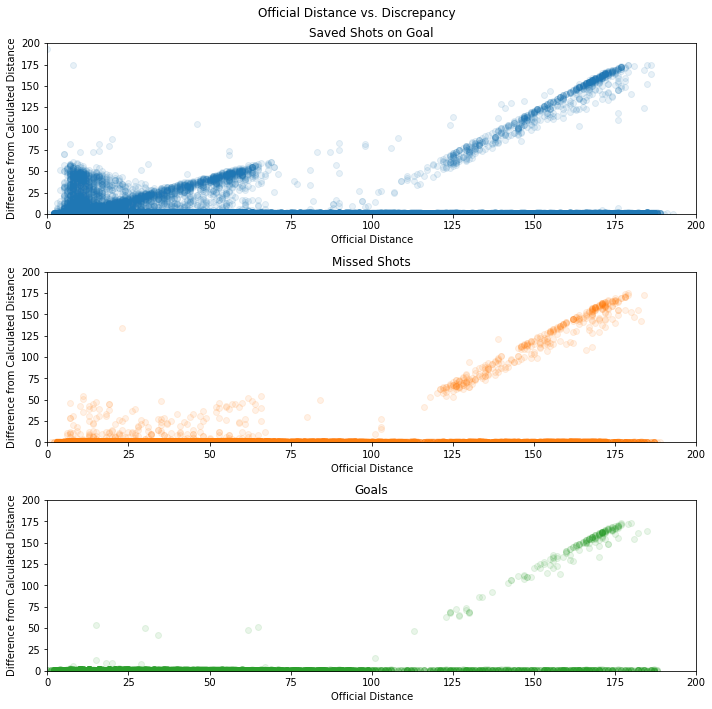

In [40]:
fig, axs = plt.subplots(3,1, figsize=(10,10));
for i in range(3):
    axs[i].set_xlabel('Official Distance');
    axs[i].set_ylabel('Difference from Calculated Distance');
    axs[i].set_xlim(0,200);
    axs[i].set_ylim(0,200);
axs[0].scatter(x='shot_dist', y='dist_difference', data=shots_df[shots_df.event=='SHOT'], label=event_type, 
               color=next(axs[0]._get_lines.prop_cycler)['color'], alpha=0.1);
axs[0].set_title('Saved Shots on Goal');
axs[1].scatter(x='shot_dist', y='dist_difference', data=shots_df[shots_df.event=='MISS'], label=event_type, 
               color=next(axs[0]._get_lines.prop_cycler)['color'], alpha=0.1);
axs[1].set_title('Missed Shots');
axs[2].scatter(x='shot_dist', y='dist_difference', data=shots_df[shots_df.event=='GOAL'], label=event_type, 
               color=next(axs[0]._get_lines.prop_cycler)['color'], alpha=0.1);
axs[2].set_title('Goals');
plt.suptitle('Official Distance vs. Discrepancy');
fig.tight_layout()

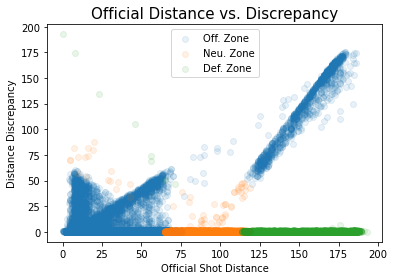

In [41]:
event_zones = shots_df.event_zone.unique()
for zone in event_zones:
    plt.scatter(x='shot_dist', y='dist_difference', data=shots_df[shots_df.event_zone==zone], label=zone, alpha=0.1);
plt.xlabel('Official Shot Distance');
plt.ylabel('Distance Discrepancy');
plt.title('Official Distance vs. Discrepancy', fontsize=15);
plt.legend();

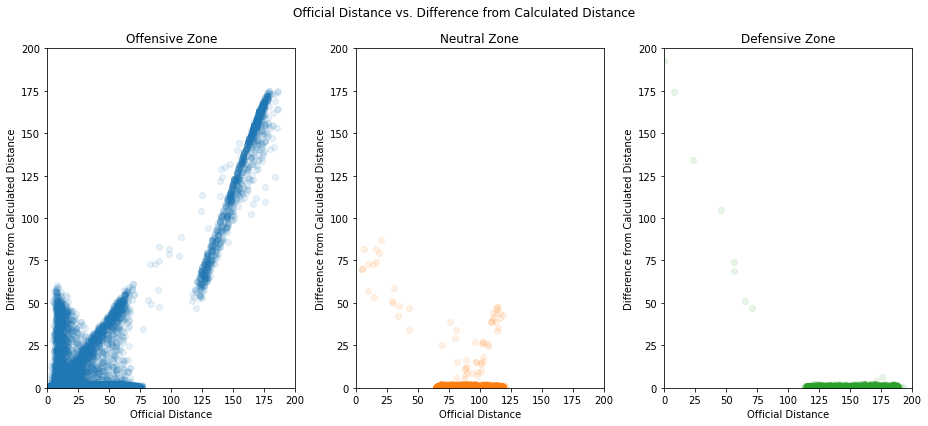

In [42]:
fig, axs = plt.subplots(1,3,figsize=(13,6));
for i in range(3):
    axs[i].set_xlabel('Official Distance');
    axs[i].set_ylabel('Difference from Calculated Distance');
    axs[i].set_xlim(0,200);
    axs[i].set_ylim(0,200);
axs[0].scatter(x='shot_dist', y='dist_difference', data=shots_df[shots_df.event_zone=='Off. Zone'], label=zone,  
               color=next(axs[0]._get_lines.prop_cycler)['color'], alpha=0.1);
axs[0].set_title('Offensive Zone');
axs[1].scatter(x='shot_dist', y='dist_difference', data=shots_df[shots_df.event_zone=='Neu. Zone'], label=zone,  
               color=next(axs[0]._get_lines.prop_cycler)['color'], alpha=0.1);
axs[1].set_title('Neutral Zone');
axs[2].scatter(x='shot_dist', y='dist_difference', data=shots_df[shots_df.event_zone=='Def. Zone'], label=zone,  
               color=next(axs[0]._get_lines.prop_cycler)['color'], alpha=0.1);
axs[2].set_title('Defensive Zone');
plt.suptitle('Official Distance vs. Difference from Calculated Distance');

fig.tight_layout()

The anomolies which were called out for correction seem to have largely disappeared. At this point, the `calc_dist` field is likely to be more accurate, so will be the only distance field retained. Likewise, `dist_difference` is no longer required

In [43]:
shots_df.drop(['shot_dist', 'dist_difference'], axis=1, inplace=True)

In [44]:
shots_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1113679 entries, 0 to 1529859
Data columns (total 33 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   game_id            1113679 non-null  object 
 1   season             1113679 non-null  object 
 2   is_playoff_game    1113679 non-null  bool   
 3   venue              1113679 non-null  object 
 4   att_code           1113679 non-null  object 
 5   def_code           1113679 non-null  object 
 6   is_home            1113679 non-null  bool   
 7   period             1113679 non-null  int64  
 8   cum_time_elapsed   1113679 non-null  int64  
 9   is_overtime        1113679 non-null  bool   
 10  seconds_remaining  1113679 non-null  int64  
 11  strength           1113679 non-null  object 
 12  att_score          1113679 non-null  int32  
 13  def_score          1113679 non-null  int32  
 14  lead_size          1113679 non-null  int32  
 15  event              1113679 non-n

The preceding analysis also provided reasons to believe that, while `secondary_type` and `shot_type` both provide shot-type information, `secondary_type` is likely to be more accurate when it is provided.

In [45]:
shot_types = np.where(shots_df.secondary_type.isna(), shots_df.shot_type, shots_df.secondary_type)
shots_df['shot_type'] = shot_types

In [46]:
shots_df.drop(['secondary_type'], axis=1, inplace=True)

In [47]:
shots_df['shot_type'].unique()

array(['Snap Shot', 'Wrist', 'Wrist Shot', 'Slap Shot', 'Snap', 'Slap',
       'Backhand', 'Tip-In', 'Deflected', 'Wrap-around', None, nan],
      dtype=object)

This introduced some duplication, as any type suffixed by `Shot` is the same as that type without the suffix. Additionally, the values with hyphens could create concerns later.

In [48]:
shot_types = {
    'Snap Shot': 'Snap',
    'Wrist Shot': 'Wrist',
    'Slap Shot': 'Slap',
    'Tip-In': 'Tip',
    'Wrap-around': 'Wrap',
}
shots_df['shot_type'].replace(shot_types, inplace=True)

In [49]:
shots_df['shot_type'].unique()

array(['Snap', 'Wrist', 'Slap', 'Backhand', 'Tip', 'Deflected', 'Wrap',
       None, nan], dtype=object)

In [50]:
shots_df['shot_type'].fillna(value='Unknown', inplace=True)

In [51]:
shots_df['shot_type'].unique()

array(['Snap', 'Wrist', 'Slap', 'Backhand', 'Tip', 'Deflected', 'Wrap',
       'Unknown'], dtype=object)

In [52]:
shots_df['shot_type'].value_counts()

Wrist        557134
Slap         216587
Snap         152557
Backhand      84798
Tip           67367
Deflected     24144
Wrap          11017
Unknown          75
Name: shot_type, dtype: int64

In [53]:
shots_df['shot_type'].describe()

count     1113679
unique          8
top         Wrist
freq       557134
Name: shot_type, dtype: object

In [54]:
shots_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1113679 entries, 0 to 1529859
Data columns (total 32 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   game_id            1113679 non-null  object 
 1   season             1113679 non-null  object 
 2   is_playoff_game    1113679 non-null  bool   
 3   venue              1113679 non-null  object 
 4   att_code           1113679 non-null  object 
 5   def_code           1113679 non-null  object 
 6   is_home            1113679 non-null  bool   
 7   period             1113679 non-null  int64  
 8   cum_time_elapsed   1113679 non-null  int64  
 9   is_overtime        1113679 non-null  bool   
 10  seconds_remaining  1113679 non-null  int64  
 11  strength           1113679 non-null  object 
 12  att_score          1113679 non-null  int32  
 13  def_score          1113679 non-null  int32  
 14  lead_size          1113679 non-null  int32  
 15  event              1113679 non-n

In [55]:
shots_df.isna().sum()

game_id                0
season                 0
is_playoff_game        0
venue                  0
att_code               0
def_code               0
is_home                0
period                 0
cum_time_elapsed       0
is_overtime            0
seconds_remaining      0
strength               0
att_score              0
def_score              0
lead_size              0
event                  0
att_players          175
att_skaters          175
att_forwards         175
def_players          175
def_skaters          175
def_forwards         175
is_extra_attacker      0
is_empty_net           0
event_zone             0
shot_type              0
event_coord_x         21
event_coord_y         20
is_rebound             0
calc_dist             24
result                 0
is_goal                0
dtype: int64

All of the player count categories correspond to each other, as these were intentionally made null earlier. This leaves the coordinate categories. A quick check shows that `calc_dist` is null if and only if one of the coordinate categories is null. The coordinate categories will be imputed with the median later.

In [56]:
shots_df[shots_df.event_coord_x.isna() | shots_df.event_coord_y.isna()].calc_dist.isna().sum()

24

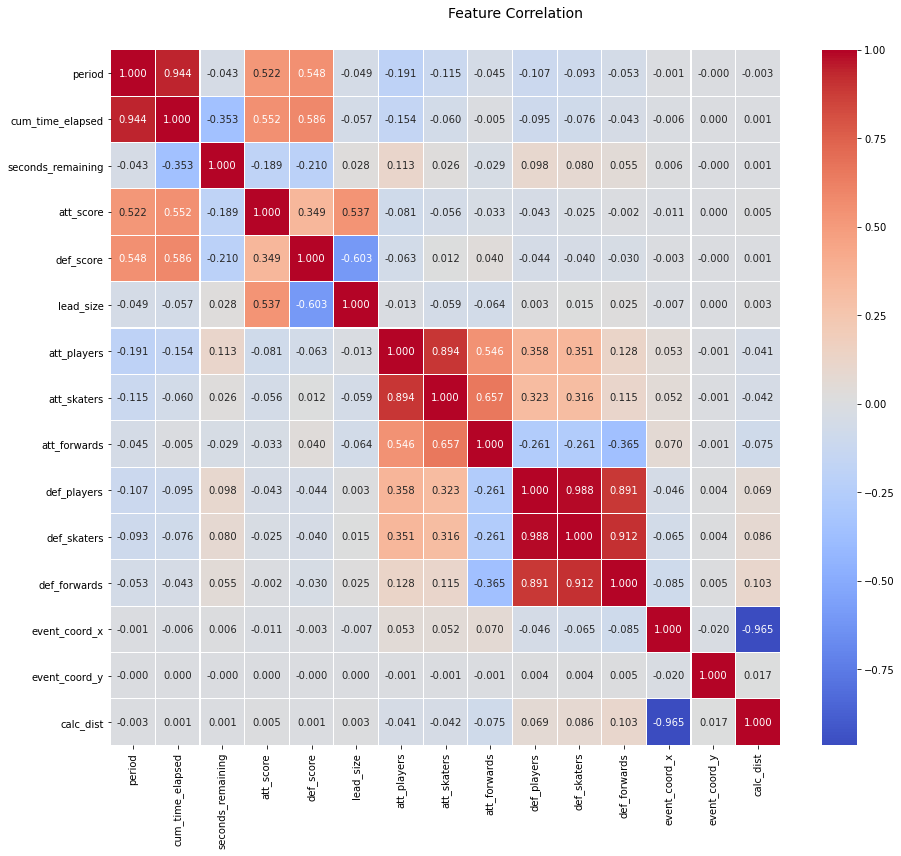

In [57]:
corrmat = shots_df.select_dtypes(include='number').corr();
fig, ax = plt.subplots(figsize=(15, 12));
hm = sns.heatmap(round(corrmat,3), annot=True, ax=ax, cmap="coolwarm",fmt='.3f', linewidths=.05);
fig.subplots_adjust(top=0.93);
fig.suptitle('Feature Correlation', fontsize=14);

There is nothing here that couldn't have been anticipated from knowledge of how fields are defined and the rules of the game. For example, periods are 20 minutes in length, so the high correlation between `period` and `cum_time_elapsed` is expected. Less obvious, but still a consequence of rules, are the negative correlations between the time and player count fields. This is because regular season overtimes are generally played 3-on-3 with 4 players / 3 skaters per team. This rule began in the 2015-16 season. Prior to that, regular season overtimes involved 4-on-4 play.

There is a strategic consideration that shows here. The field `lead_size` has a small negative correlation with `att_skaters` and `att_forwards` which has no symmetric correspondent in the defending team fields. This would reflect the strategic choice for the trailing team to pull their goalie for an extra attacker late in games.

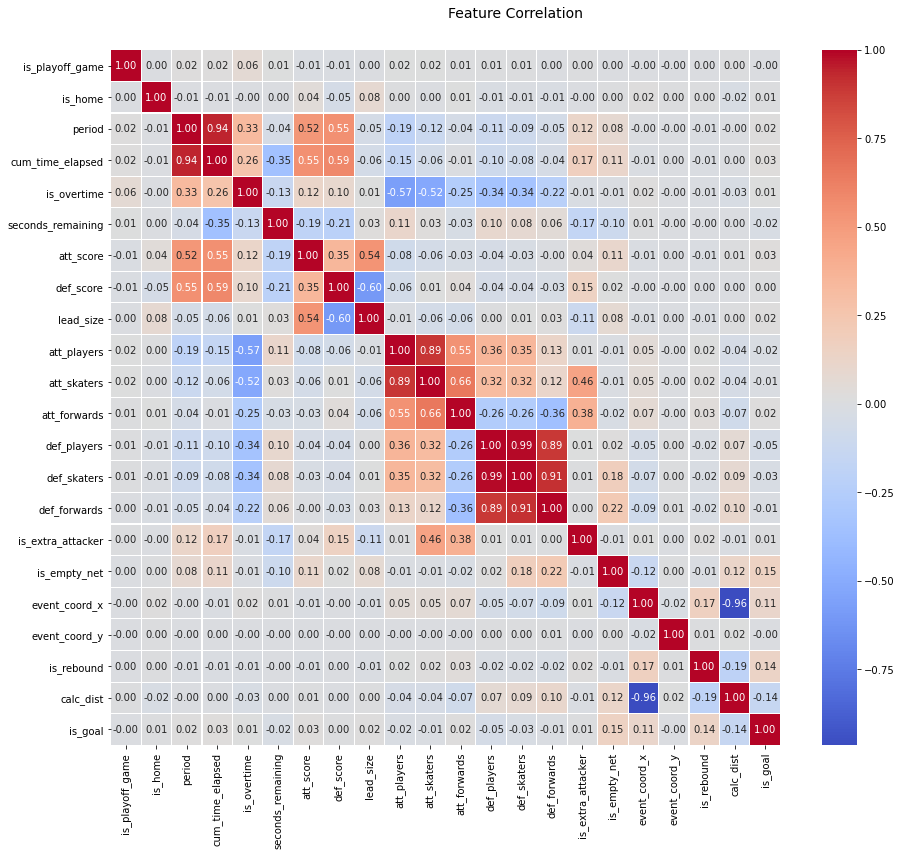

In [58]:
corrmat = shots_df.corr();
fig, ax = plt.subplots(figsize=(15, 12));
hm = sns.heatmap(round(corrmat,3), annot=True, ax=ax, cmap="coolwarm",fmt='.2f', linewidths=.05);
fig.subplots_adjust(top=0.93);
fig.suptitle('Feature Correlation', fontsize=14);

The correlation between `is_overtime` and `lead_size` should be perfectly 0, as `lead_size` should always be 0 in overtime. Overtimes in the NHL are sudden-death, where the first goal ends the game. Investigating this finds there are a handful of cases  which all seem to be a result of the play ordering placing the goal before shots leading to a rebound. There are few enough of these that it shouldn't be an issue.

In [59]:
shots_df[shots_df.is_overtime].lead_size.value_counts()

0    20897
1        3
Name: lead_size, dtype: int64

In [60]:
shots_df.reset_index(drop=True, inplace=True)
shots_df[(shots_df.is_overtime) & (shots_df.lead_size > 0)]

,game_id,season,is_playoff_game,venue,att_code,def_code,is_home,period,cum_time_elapsed,is_overtime,seconds_remaining,strength,att_score,def_score,lead_size,event,att_players,att_skaters,att_forwards,def_players,def_skaters,def_forwards,is_extra_attacker,is_empty_net,event_zone,shot_type,event_coord_x,event_coord_y,is_rebound,calc_dist,result,is_goal
25566,2010020308,20102011,False,Nassau Coliseum,CBJ,NYI,False,4,3751,True,149,EV,4,3,1,SHOT,5,4,2,5,4,2,False,False,Off. Zone,Wrist,82.0,-5.0,True,8.602325,Save,False
327885,2013020539,20132014,False,Canadian Tire Centre,PHX,OTT,False,4,3743,True,157,EV,4,3,1,SHOT,5,4,2,5,4,2,False,False,Off. Zone,Slap,32.0,20.0,True,60.406953,Save,False
1102636,2020020436,20202021,False,Nationwide Arena,CBJ,DAL,True,4,3895,True,5,EV,4,3,1,SHOT,4,3,2,4,3,2,False,False,Off. Zone,Wrist,80.0,-5.0,True,10.295630,Save,False


In [61]:
pd.concat([shots_df[25565:25567], shots_df[327884:327886], shots_df[1102635:1102637]])

,game_id,season,is_playoff_game,venue,att_code,def_code,is_home,period,cum_time_elapsed,is_overtime,seconds_remaining,strength,att_score,def_score,lead_size,event,att_players,att_skaters,att_forwards,def_players,def_skaters,def_forwards,is_extra_attacker,is_empty_net,event_zone,shot_type,event_coord_x,event_coord_y,is_rebound,calc_dist,result,is_goal
25565,2010020308,20102011,False,Nassau Coliseum,CBJ,NYI,False,4,3751,True,149,EV,3,3,0,GOAL,5,4,2,5,4,2,False,False,Off. Zone,Tip,80.0,4.0,False,9.848858,Goal,True
25566,2010020308,20102011,False,Nassau Coliseum,CBJ,NYI,False,4,3751,True,149,EV,4,3,1,SHOT,5,4,2,5,4,2,False,False,Off. Zone,Wrist,82.0,-5.0,True,8.602325,Save,False
327884,2013020539,20132014,False,Canadian Tire Centre,PHX,OTT,False,4,3743,True,157,EV,3,3,0,GOAL,5,4,2,5,4,2,False,False,Off. Zone,Backhand,81.0,-1.0,False,8.062258,Goal,True
327885,2013020539,20132014,False,Canadian Tire Centre,PHX,OTT,False,4,3743,True,157,EV,4,3,1,SHOT,5,4,2,5,4,2,False,False,Off. Zone,Slap,32.0,20.0,True,60.406953,Save,False
1102635,2020020436,20202021,False,Nationwide Arena,CBJ,DAL,True,4,3895,True,5,EV,3,3,0,GOAL,4,3,2,4,3,2,False,False,Off. Zone,Wrist,84.0,-6.0,True,7.810250,Goal,True
1102636,2020020436,20202021,False,Nationwide Arena,CBJ,DAL,True,4,3895,True,5,EV,4,3,1,SHOT,4,3,2,4,3,2,False,False,Off. Zone,Wrist,80.0,-5.0,True,10.295630,Save,False


In [62]:
img = mpimg.imread('NHL_Hockey_Rink.png')

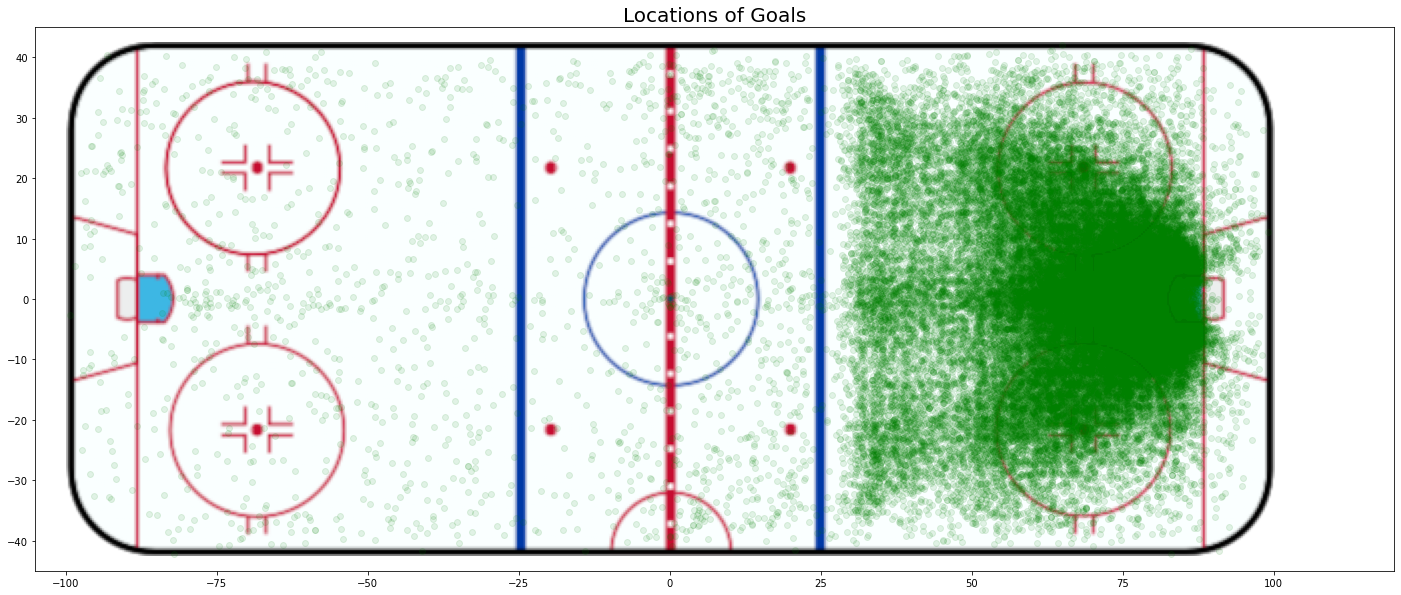

In [63]:
fig=plt.figure(figsize = (25,10))
ax=fig.add_subplot(1,1,1)
ax.set_aspect('equal')
ax.set_xlim((-105,120))
ax.set_ylim((-45,45))
plt.imshow(img, origin='lower', extent=(-100,100,-42.5,42.5));

plt.scatter(x=np.where(shots_df['is_goal']==True,shots_df['event_coord_x'],None), 
            y=np.where(shots_df['is_goal']==True,shots_df['event_coord_y'],None), 
            c='green', alpha=0.1, label='goal');

dots = ax.collections[-1]
offsets = dots.get_offsets()
jittered_offsets = offsets + np.random.uniform(-0.5, 0.5, offsets.shape)
dots.set_offsets(jittered_offsets)

plt.title('Locations of Goals', fontsize=20);

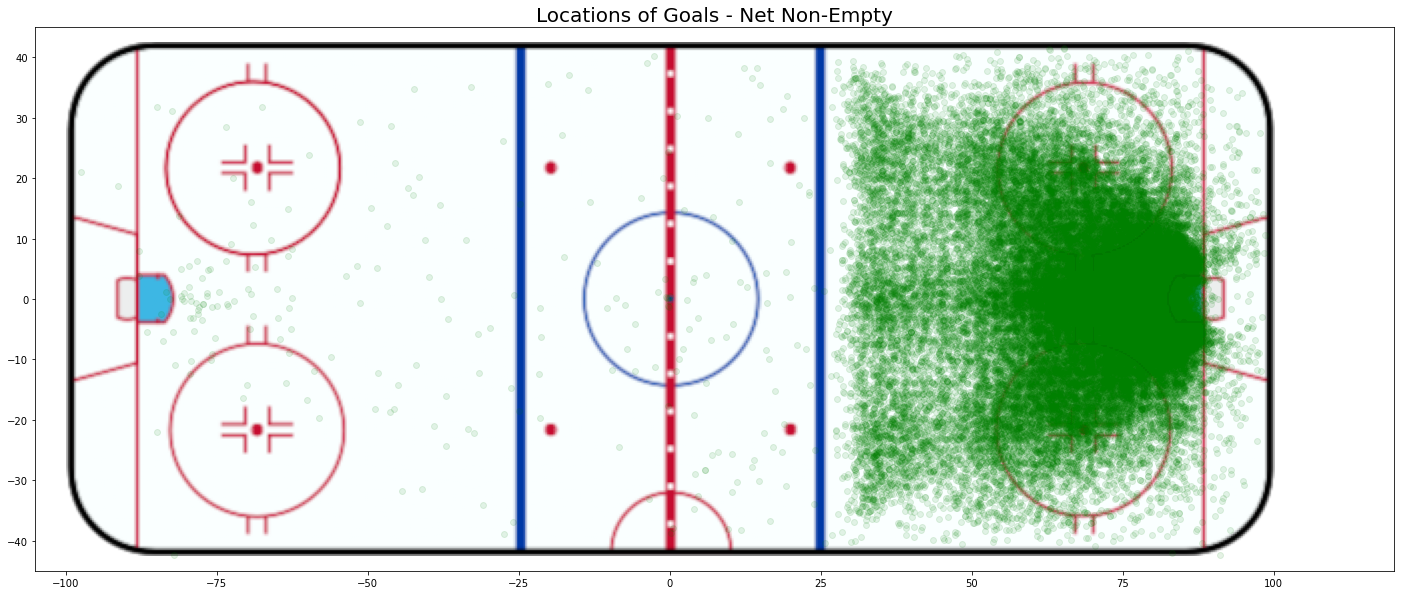

In [64]:
fig=plt.figure(figsize = (25,10))
ax=fig.add_subplot(1,1,1)
ax.set_aspect('equal')
ax.set_xlim((-105,120))
ax.set_ylim((-45,45))
plt.imshow(img, origin='lower', extent=(-100,100,-42.5,42.5));

plt.scatter(x=np.where((shots_df['is_goal']==True)&(shots_df['is_empty_net']==False),shots_df['event_coord_x'],None), 
            y=np.where((shots_df['is_goal']==True)&(shots_df['is_empty_net']==False),shots_df['event_coord_y'],None), 
            c='green', alpha=0.1, label='goal');

dots = ax.collections[-1]
offsets = dots.get_offsets()
jittered_offsets = offsets + np.random.uniform(-0.5, 0.5, offsets.shape)
dots.set_offsets(jittered_offsets)

plt.title('Locations of Goals - Net Non-Empty', fontsize=20);

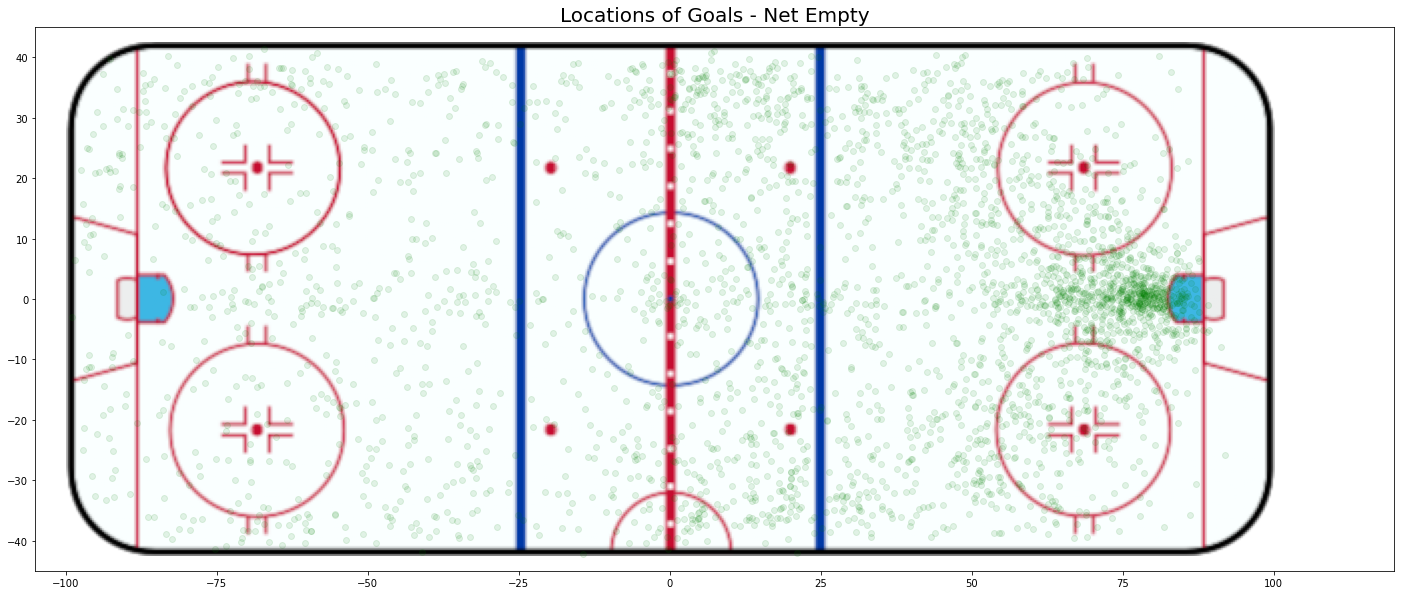

In [65]:
fig=plt.figure(figsize = (25,10))
ax=fig.add_subplot(1,1,1)
ax.set_aspect('equal')
ax.set_xlim((-105,120))
ax.set_ylim((-45,45))
plt.imshow(img, origin='lower', extent=(-100,100,-42.5,42.5));

plt.scatter(x=np.where((shots_df['is_goal']==True)&(shots_df['is_empty_net']==True),shots_df['event_coord_x'],None), 
            y=np.where((shots_df['is_goal']==True)&(shots_df['is_empty_net']==True),shots_df['event_coord_y'],None), 
            c='green', alpha=0.1, label='goal');

dots = ax.collections[-1]
offsets = dots.get_offsets()
jittered_offsets = offsets + np.random.uniform(-0.5, 0.5, offsets.shape)
dots.set_offsets(jittered_offsets)

plt.title('Locations of Goals - Net Empty', fontsize=20);

As stated earlier, it is clear that shots are more likely to be successful when taken with fewer defenders on the ice. This is particularly clear when removing empty net shot attempts from consideration.

In [66]:
pd.pivot_table(shots_df, index=['att_skaters', 'def_skaters'], values='is_goal', aggfunc=['count', 'sum', 'mean'])

count     sum      mean
                        is_goal is_goal   is_goal
att_skaters def_skaters                          
3           3              7182     829  0.115427
            4               160       9  0.056250
            5               135       9  0.066667
            6                 2       0  0.000000
4           3              3289     379  0.115233
            4             22463    1483  0.066020
            5             25870    1830  0.070738
            6               370     194  0.524324
5           3              5794     885  0.152744
            4            157726   14034  0.088977
            5            866352   48493  0.055974
            6              4665    2865  0.614148
6           3                85      14  0.164706
            4              2495     220  0.088176
            5             16916    1279  0.075609

In [67]:
pd.pivot_table(shots_df[~shots_df['is_empty_net']], index=['att_skaters', 'def_skaters'], values='is_goal', 
               aggfunc=['count', 'sum', 'mean'])

count     sum      mean
                        is_goal is_goal   is_goal
att_skaters def_skaters                          
3           3              7182     829  0.115427
            4               160       9  0.056250
            5               133       8  0.060150
4           3              3289     379  0.115233
            4             22460    1480  0.065895
            5             25785    1783  0.069149
5           3              5794     885  0.152744
            4            157720   14031  0.088961
            5            866159   48361  0.055834
6           3                85      14  0.164706
            4              2495     220  0.088176
            5             16916    1279  0.075609

In [68]:
pd.pivot_table(shots_df[~shots_df['is_empty_net']], index=['def_skaters'], values='is_goal', 
               aggfunc=['count', 'sum', 'mean'])

,count,sum,mean
,is_goal,is_goal,is_goal
def_skaters,,,
3,16350,2107,0.128869
4,182835,15740,0.086089
5,908993,51431,0.056580


In [69]:
pd.pivot_table(shots_df, index=['att_skaters', 'def_skaters'], columns='period', values='is_goal', aggfunc="mean")

period                          1         2         3         4         5  \
att_skaters def_skaters                                                     
3           3            0.000000  0.500000  0.100000  0.115267       NaN   
            4            0.071429  0.000000  0.136364  0.051546       NaN   
            5            0.045455  0.071429  0.085714       NaN       NaN   
            6                 NaN       NaN  0.000000       NaN       NaN   
4           3            0.100559  0.092308  0.124138  0.121964       NaN   
            4            0.054372  0.072764  0.071458  0.063596       NaN   
            5            0.065098  0.072429  0.074137  0.032258  0.166667   
            6                 NaN  0.333333  0.525886       NaN       NaN   
5           3            0.156721  0.153333  0.149184  0.052632       NaN   
            4            0.086551  0.090087  0.090246  0.080000  0.080000   
            5            0.052916  0.058999  0.055994  0.051394  0.062500   
            6            0.750000  0.000000  0.614559       NaN       NaN   
6           3            0.000000  0.000000  0.170732       NaN       NaN   
            4            0.013158  0.010638  0.093763       NaN       NaN   
            5            0.066667  0.091386  0.074811  0.400000       NaN   

period                          6    7         8  
att_skaters def_skaters                           
3           3                 NaN  NaN       NaN  
            4                 NaN  NaN       NaN  
            5                 NaN  NaN       NaN  
            6                 NaN  NaN       NaN  
4           3                 NaN  NaN       NaN  
            4                 NaN  NaN       NaN  
            5                 NaN  NaN       NaN  
            6                 NaN  NaN       NaN  
5           3                 NaN  NaN       NaN  
            4            0.000000  NaN  0.000000  
            5            0.065217  0.0  0.090909  
            6                 NaN  NaN       NaN  
6           3                 NaN  NaN       NaN  
            4                 NaN  NaN       NaN  
            5                 NaN  NaN       NaN

In [70]:
pd.pivot_table(shots_df, index=['att_skaters', 'def_skaters'], columns='period', values='is_goal', aggfunc="count")

period                          1         2         3       4      5     6  \
att_skaters def_skaters                                                      
3           3                 2.0       4.0      10.0  7166.0    NaN   NaN   
            4                14.0      27.0      22.0    97.0    NaN   NaN   
            5                44.0      56.0      35.0     NaN    NaN   NaN   
            6                 NaN       NaN       2.0     NaN    NaN   NaN   
4           3               358.0     520.0     435.0  1976.0    NaN   NaN   
            4              4083.0    5882.0    4856.0  7642.0    NaN   NaN   
            5              7650.0   10562.0    7621.0    31.0    6.0   NaN   
            6                 NaN       3.0     367.0     NaN    NaN   NaN   
5           3              1659.0    2400.0    1716.0    19.0    NaN   NaN   
            4             50479.0   61962.0   44999.0   225.0   50.0  10.0   
            5            292688.0  297412.0  272583.0  2977.0  560.0  92.0   
            6                 4.0       4.0    4657.0     NaN    NaN   NaN   
6           3                 1.0       2.0      82.0     NaN    NaN   NaN   
            4                76.0      94.0    2325.0     NaN    NaN   NaN   
            5              1260.0    1335.0   14316.0     5.0    NaN   NaN   

period                      7     8  
att_skaters def_skaters              
3           3             NaN   NaN  
            4             NaN   NaN  
            5             NaN   NaN  
            6             NaN   NaN  
4           3             NaN   NaN  
            4             NaN   NaN  
            5             NaN   NaN  
            6             NaN   NaN  
5           3             NaN   NaN  
            4             NaN   1.0  
            5            29.0  11.0  
            6             NaN   NaN  
6           3             NaN   NaN  
            4             NaN   NaN  
            5             NaN   NaN

In [71]:
pd.pivot_table(shots_df, index=['att_skaters', 'def_skaters'], columns='period', values='is_goal', aggfunc="sum")

period                         1        2        3      4     5    6    7    8
att_skaters def_skaters                                                       
3           3                0.0      2.0      1.0  826.0   NaN  NaN  NaN  NaN
            4                1.0      0.0      3.0    5.0   NaN  NaN  NaN  NaN
            5                2.0      4.0      3.0    NaN   NaN  NaN  NaN  NaN
            6                NaN      NaN      0.0    NaN   NaN  NaN  NaN  NaN
4           3               36.0     48.0     54.0  241.0   NaN  NaN  NaN  NaN
            4              222.0    428.0    347.0  486.0   NaN  NaN  NaN  NaN
            5              498.0    765.0    565.0    1.0   1.0  NaN  NaN  NaN
            6                NaN      1.0    193.0    NaN   NaN  NaN  NaN  NaN
5           3              260.0    368.0    256.0    1.0   NaN  NaN  NaN  NaN
            4             4369.0   5582.0   4061.0   18.0   4.0  0.0  NaN  0.0
            5            15488.0  17547.0  15263.0  153.0  35.0  6.0  0.0  1.0
            6                3.0      0.0   2862.0    NaN   NaN  NaN  NaN  NaN
6           3                0.0      0.0     14.0    NaN   NaN  NaN  NaN  NaN
            4                1.0      1.0    218.0    NaN   NaN  NaN  NaN  NaN
            5               84.0    122.0   1071.0    2.0   NaN  NaN  NaN  NaN

Most of the larger probabilities by period are a function of the event rarely happening. It does seem intriguing that 5-on-5 goals seem to be more common in the second period than in the first or third.

In [72]:
count = np.array([15488, 17547])
nobs = np.array([292688, 297412])
stat, pval = proportions_ztest(count, nobs)
print(f'Likelihood of 5-on-5 goals, first vs. second periods; p = {pval:0.3f}')

Likelihood of 5-on-5 goals, first vs. second periods; p = 0.000


In [73]:
count = np.array([17547, 15263])
nobs = np.array([297412, 272583])
stat, pval = proportions_ztest(count, nobs)
print(f'Likelihood of 5-on-5 goals, second vs. third periods; p = {pval:0.3f}')

Likelihood of 5-on-5 goals, second vs. third periods; p = 0.000


It seems that the difference between periods is statistically significant. This is something that could be investigated further. There are rule-based reasons why second-period goals may be more likely. In particular, the teams change sides between periods. In the second period, goaltenders are further from their team's bench than in the first period. This makes it more difficult to make substitutions without allowing a scoring chance.

In [74]:
road_v_home = pd.pivot_table(shots_df, index='is_home', values='is_goal', aggfunc=['count', 'sum', 'mean'])
road_shots = road_v_home.loc[False, 'count']['is_goal']
road_goals = road_v_home.loc[False, 'sum']['is_goal']
home_shots = road_v_home.loc[True, 'count']['is_goal']
home_goals = road_v_home.loc[True, 'sum']['is_goal']
road_v_home

,count,sum,mean
,is_goal,is_goal,is_goal
is_home,,,
False,540520,34522,0.063868
True,573159,38001,0.066301


Home goals are more common than road goals. Again, this can be tested for statistical significance.

In [75]:
count = np.array([home_goals, road_goals])
nobs = np.array([home_shots, road_shots])
stat, pval = proportions_ztest(count, nobs)
print(f'Likelihood of goals, home vs. road team; p = {pval:0.3f}')

Likelihood of goals, home vs. road team; p = 0.000


Again, this is statistically significant, indicating that there is an advantage to playing at home. Some of this is rule-based, as there are rules relating to line changes that favor the home team. Some may be due to the environment as well. Future investigation could examine whether this difference is maintained in neutral ice games, where there are still designated home and visiting teams.

In [76]:
pd.pivot_table(shots_df, index='is_rebound', values='is_goal', aggfunc=['count', 'sum', 'mean'])

,count,sum,mean
,is_goal,is_goal,is_goal
is_rebound,,,
False,1034776,57592,0.055656
True,78903,14931,0.189232


Unsurprisingly, there is a major difference between rebound and non-rebound opportunities.

In [77]:
pd.pivot_table(shots_df, index='shot_type', values='is_goal', aggfunc=['count', 'sum', 'mean'])

,count,sum,mean
,is_goal,is_goal,is_goal
shot_type,,,
Backhand,84798,7018,0.082761
Deflected,24144,2322,0.096173
Slap,216587,8595,0.039684
Snap,152557,10662,0.069889
Tip,67367,6953,0.103211
Unknown,75,53,0.706667
Wrap,11017,567,0.051466
Wrist,557134,36353,0.065250


There also seems to be a relationship between shot-selection and goals. This is also unsurprising, as slap shots are generally from longer distances while tip-ins are just in front of the net.

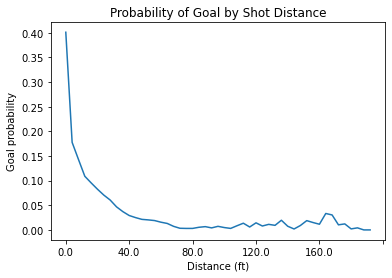

In [78]:
n_bins = 51
no_empty_net = shots_df[~shots_df['is_empty_net']].copy()
no_empty_net['dist_bins'] = pd.cut(no_empty_net['calc_dist'], bins=np.linspace(0, 200, n_bins))
dist_probs = pd.pivot_table(no_empty_net, index='dist_bins', values='is_goal', aggfunc=('count','sum','mean')).reset_index()
dist_probs['mark'] = dist_probs.dist_bins.apply(lambda x: x.left)
dist_probs.plot(x='mark', y='mean', title='Probability of Goal by Shot Distance', \
                xlabel='Distance (ft)', ylabel= 'Goal probability', legend=False);

There seems to be a near-exponential decline in likelihood of scoring goals as shots are taken further from the net.

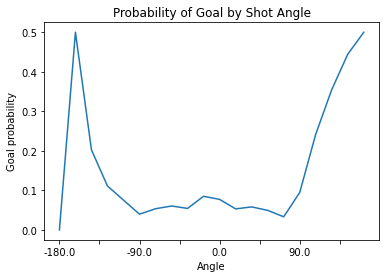

In [79]:
n_bins = 21
no_empty_net['calc_angle'] = np.arctan2(no_empty_net['event_coord_y'], 89 - no_empty_net['event_coord_x']) * 180 / np.pi
no_empty_net['angle_bins'] = pd.cut(no_empty_net['calc_angle'], bins=np.linspace(-180, 180, n_bins))
angle_probs = pd.pivot_table(no_empty_net, index='angle_bins', values='is_goal', aggfunc=('count','sum','mean')).reset_index()
angle_probs['mark'] = angle_probs.angle_bins.apply(lambda x: x.left)
angle_probs.plot(x='mark', y='mean', title='Probability of Goal by Shot Angle', \
                xlabel='Angle', ylabel= 'Goal probability', legend=False);

It appears that shots taken from extreme angles

In [80]:
pd.pivot_table(shots_df[~shots_df['is_empty_net']], index='att_forwards', values='is_goal', aggfunc=['count', 'sum', 'mean'])

,count,sum,mean
,is_goal,is_goal,is_goal
att_forwards,,,
1,609,39,0.064039
2,60266,4390,0.072844
3,929739,53936,0.058012
4,111219,10331,0.092889
5,6198,571,0.092126
6,147,11,0.074830


In [81]:
pd.pivot_table(shots_df[~shots_df['is_empty_net']], index='is_extra_attacker', values='is_goal', 
               aggfunc=['count', 'sum', 'mean'])

,count,sum,mean
,is_goal,is_goal,is_goal
is_extra_attacker,,,
False,1088001,67712,0.062235
True,20351,1566,0.076950


In [82]:
pd.pivot_table(shots_df[~shots_df['is_empty_net']], index='event_zone', values='is_goal', aggfunc=['count', 'sum', 'mean'])

,count,sum,mean
,is_goal,is_goal,is_goal
event_zone,,,
Def. Zone,9332,127,0.013609
Neu. Zone,26932,121,0.004493
Off. Zone,1072088,69030,0.064388


In [83]:
ADJUSTED_DATAFRAME_FILE = DATA_FOLDER + 'adjusted_cleaned_data.pkl'
current_dir = Path.cwd()
frame_path = current_dir.joinpath(ADJUSTED_DATAFRAME_FILE)
shots_df.to_pickle(str(frame_path))